In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw

In [10]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import active_gel_fem
importlib.reload(active_gel_fem)

import utils 
importlib.reload(utils)

from ngsolve.webgui import Draw

In [3]:
def plot_frame(n_samples, rho, vx, vy, nx, ny, title, stride=3):
    X = np.linspace(0, 1, n_samples)
    Y = np.linspace(0, 1, n_samples)
    X, Y = np.meshgrid(X, Y)

    # Plot the contour for rho_vals
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axes[0].contourf(X, Y, rho, levels=100, cmap='Greys')
    fig.colorbar(im0, ax=axes[0])

    mag = np.sqrt(vx**2+vy**2)
    im1 = axes[1].contourf(X, Y, mag, levels=100, cmap='Blues')
    axes[1].set_title('v')
    fig.colorbar(im1, ax=axes[1])
    axes[1].quiver(X[::stride, ::stride], Y[::stride, ::stride], 
            (vx/mag)[::stride, ::stride], (vy/mag)[::stride, ::stride], 
            color='orange', 
            width=0.003,     # Increase width to make arrow shafts thicker
            headwidth=4,     # Increase headwidth for wider arrowheads
            headlength=5,    # Increase headlength for longer arrowheads
            headaxislength=7 # Increase headaxislength for more pronounced heads
    ) 

    mag = np.sqrt(nx**2+ny**2)
    im2 = axes[2].contourf(X, Y, mag, levels=100, cmap='Blues')
    axes[2].set_title('nematic order')
    fig.colorbar(im2, ax=axes[2])
    plt.quiver(X[::stride, ::stride], Y[::stride, ::stride], 
            (nx/mag)[::stride, ::stride], (ny/mag)[::stride, ::stride], 
            color='orange', 
            width=0.003,     # Increase width to make arrow shafts thicker
            headlength=0,    
            headaxislength=0 
    ) 

    axes[0].set_title(title)
    plt.tight_layout()
    plt.savefig(f"sim_data/{title}.png", dpi=300)
    plt.show()

def run_sim(eta, beta1, beta2, chi0_active, chi1_active, T, source):
    chi0 = chi0_active
    chi1 = chi1_active
    rho0 = 1 + 1*source


    sim = active_gel_fem.NematicActiveGel2D(
                        width=1, height=1, maxh=0.03,
                        gamma=eta, eta_1=eta, eta_2=0,
                        k=1, D=1e-4,
                        kappa = 1e-4,
                        beta1 = beta1, beta2 = beta2,   
                        chi0 = chi0,  chi1 = chi1,
                        Qsq = -1 + 2*source, rho0 = rho0 
                    )
    
    for i in range(len(sim.density.vec.data)): 
        sim.density.vec.data[i] = np.random.normal(1, 0.05)
        sim.nematic_xx.vec.data[i] = np.random.normal(0, 0.05)

    sim.simulate(
        tend=T,
        tau=0.05,
        save_interval=20 # save once a second 
    )

    return sim 
    
    


In [137]:

# parameters for isotropic outward flow + no source term for nematic order + no source for spontanous nematic order 
# T = 5
# tau = 0.01 
# eta = 1 
# chi0 = 10
# chi1 = 6
# beta_prod = 1
# beta2 = 2
# beta1 = 10 
# kappa = 0.01 


T = 100
tau = 0.1
chi0 = 0.01
chi1 = 0.1
beta_prod = 1e-4
beta2 = 1
beta1 = beta_prod/beta2
eta = 1 



tanh = lambda arg: (exp(arg) - exp(-arg))/(exp(arg)+exp(-arg)) 
left_edge = 0.5 - 0.06
right_edge = 0.5 + 0.06
left_transition = 0.5 * (tanh((x - left_edge)/0.005))
right_transition = 0.5 * (tanh((right_edge - x)/0.005))

half_length = lambda t: 0.1
bottom_transition = lambda t: 0.5 * (tanh((y - (0.1-half_length(t)))/0.1))
top_transition = lambda t: 0.5 * (tanh((0.9 + half_length(t)- y)/0.1))
source = lambda t: 1*(left_transition + right_transition) *(top_transition(t) + bottom_transition(t))


sim = active_gel_fem.NematicActiveGel2D(
                    width=1, height=1, maxh=0.03,
                    gamma=eta, eta_1=eta, eta_2=0,
                    k=1, D=1e-4,
                    kappa =1e-4,
                    beta1 = beta1, beta2 = beta2,   
                    chi0 = chi0,  chi1 = chi1,
                    Qsq = lambda t: -1 + 2*source(t), 
                    rho0 = lambda t: 0.1+ 1*source(t))

sim.density.Set(0.1)

# for i in range(len(sim.density.vec.data)): 
#     sim.density.vec.data[i] = np.random.normal(1, 0.05)
#     sim.nematic_xx.vec.data[i] = np.random.normal(0, 0.05)

sim.simulate(
    tend=T,
    tau=tau,
    save_interval=int(1/tau) # save once a second 
)

  4%|▍         | 40/1000 [00:00<00:04, 198.57it/s]

craete bilinearformapplication


100%|██████████| 1000/1000 [00:05<00:00, 197.91it/s]


In [138]:
sim.visualize(animate=False)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [139]:
filename = 'sim_data/test'

n_samples = 50
data= sim.export_to_npy(filename, n_samples=n_samples)

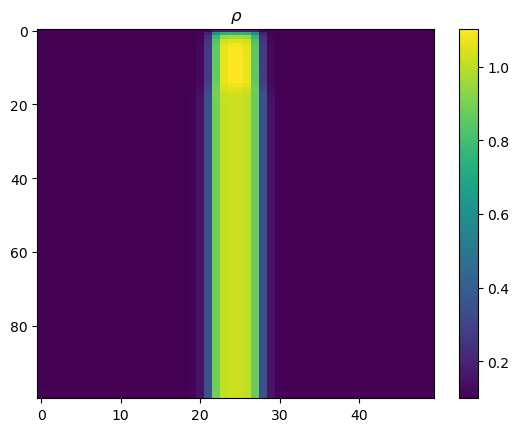

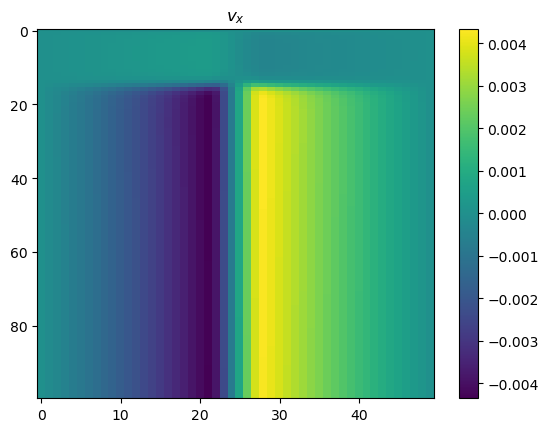

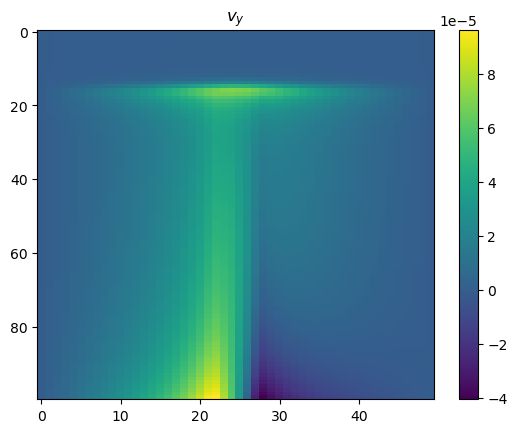

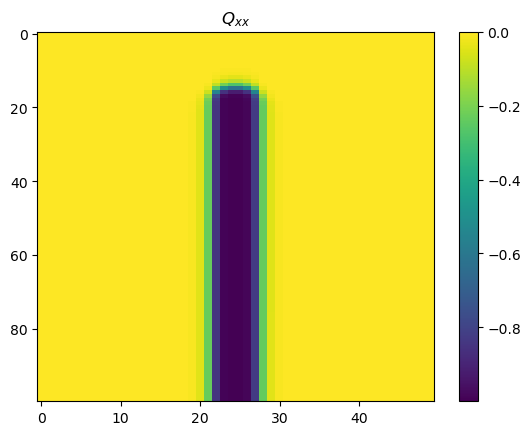

In [140]:
plt.imshow(data[:, 24, :, 0], aspect='auto', interpolation='none')
plt.colorbar()
plt.title(r'$\rho$')
plt.show() 

plt.imshow(data[:, 24, :, 1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title(r'$v_x$')
plt.show() 

plt.imshow(data[:, 24, :, 2], aspect='auto', interpolation='none')
plt.colorbar()
plt.title(r'$v_y$')
plt.show() 

plt.imshow(data[:, 24, :, -2], aspect='auto', interpolation='none')
plt.colorbar()
plt.title(r'$Q_{xx}$')
plt.show() 

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_70464/3741422254.py:17: RuntimeWarning: invalid value encountered in divide
  (vx/mag)[::stride, ::stride], (vy/mag)[::stride, ::stride],


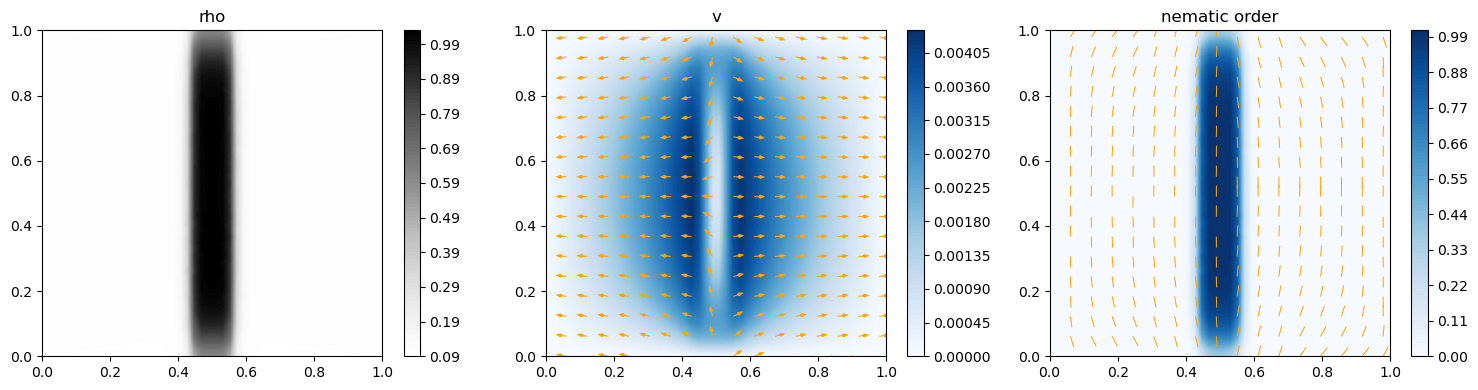

In [141]:
t = -1
rho, vx, vy, Q, q = np.rollaxis(data[t], -1)
nx, ny = utils.nematic_to_vector(Q, q)
plot_frame(n_samples, rho, vx, vy, nx, ny, title='rho', stride=3)


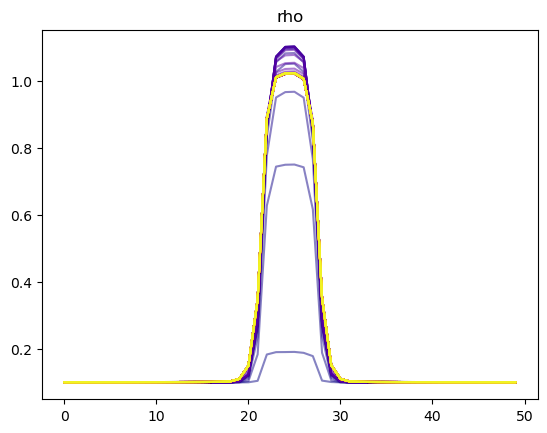

In [142]:
rho = data[:, 24,  :, 0] 
colors = plt.cm.plasma(np.linspace(0, 1, T))
for i in range(T): 
    plt.plot(rho[i], '-', alpha=0.5, color=colors[i])
plt.title('rho')
plt.show() 

In [177]:

density_frames = data[:, :, :, 0]
velocity_frames = data[:, :, :, 1:3]
nematic_frames = np.moveaxis(utils.nematic_to_vector(data[:, :, :, 3], data[:, :, :, 4]), 0, -1)
print(nematic_frames.shape)
utils.create_active_gel_video(density_frames, velocity_frames, nematic_frames, 
                            output_file='../figures/active_gel_demo.mp4',
                            fps=1, skip=5, vector_scale=0.1, 
                            arrow_width=1)   




(10, 50, 50, 2)
Processing frame 0/10
Video saved to ../figures/active_gel_demo.mp4


In [43]:
from ngsolve import *
from netgen.occ import *
from ngsolve.webgui import Draw

In [41]:
class gel_circle(active_gel_fem.NematicActiveGel2D):

    def _create_mesh(self):
        shape = Circle((0, 0), r=self.width).Face()
        shape.edges.name = 'cyl'
        self.mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.04)).Curve(3)

    def _setup_function_spaces(self):
        """Set up the function spaces for velocity, nematic order and density fields."""
        self.V = VectorH1(self.mesh, order=2, dirichlet="cyl")  # velocity field
        self.R = H1(self.mesh, order=2)  # density field

        self.Q = H1(self.mesh, order=2) #Qxx
        self.q = H1(self.mesh, order=2) #Qxy

        self.X = self.V * self.R * self.Q * self.q
        
        self.gfu = GridFunction(self.X)
        self.velocity, self.density, self.nematic_xx, self.nematic_yx= self.gfu.components
